<a href="https://colab.research.google.com/github/amriteshwarpandey/Amriteshwar_resume/blob/main/Alpha_Thalassemia_Prediction_using_Machine_Learning_Approaches_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')

In [2]:
# --- 1. Data Generation ---
# As per the paper, a synthetic dataset is needed. We generate one that mimics
# the distributions shown in the paper's figures.
def generate_synthetic_data():
    """Generates a synthetic dataset for Alpha Thalassemia prediction."""
    np.random.seed(42)
    n_samples = 200
    # Based on Figure 1: ~145 carriers, ~55 normal
    n_carriers = 145
    n_normal = 55

    # Create features for Alpha Carriers (Phenotype = 1)
    # Carriers typically have lower HGB and MCV
    age_carrier = np.random.randint(18, 65, n_carriers)
    gender_carrier = np.random.choice(['Male', 'Female'], n_carriers, p=[0.55, 0.45])
    hgb_carrier = np.random.normal(11.0, 1.0, n_carriers)
    mcv_carrier = np.random.normal(72, 5, n_carriers)
    phenotype_carrier = np.ones(n_carriers, dtype=int)

    # Create features for Normal Phenotype (Phenotype = 0)
    age_normal = np.random.randint(18, 65, n_normal)
    gender_normal = np.random.choice(['Male', 'Female'], n_normal, p=[0.5, 0.5])
    hgb_normal = np.random.normal(14.0, 1.2, n_normal)
    mcv_normal = np.random.normal(90, 5, n_normal)
    phenotype_normal = np.zeros(n_normal, dtype=int)

    # Combine data
    df = pd.DataFrame({
        'Age': np.concatenate([age_carrier, age_normal]),
        'Gender': np.concatenate([gender_carrier, gender_normal]),
        'HGB': np.concatenate([hgb_carrier, hgb_normal]),
        'MCV': np.concatenate([mcv_carrier, mcv_normal]),
        'Phenotype': np.concatenate([phenotype_carrier, phenotype_normal])
    })

    # Shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)
    df.to_csv('alpha_thalassemia_data.csv', index=False)
    return df

# Generate and load the data
data = generate_synthetic_data()
print("--- Synthetic Dataset Generated and Loaded ---")
print(data.head())
print("\n")

--- Synthetic Dataset Generated and Loaded ---
   Age  Gender        HGB        MCV  Phenotype
0   20    Male  10.249238  68.378331          1
1   64  Female  14.354661  88.353631          0
2   52    Male  10.875475  76.985576          1
3   32    Male  10.741582  70.564300          1
4   55  Female  13.103471  86.352629          0




--- Exploratory Data Analysis ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        200 non-null    int64  
 1   Gender     200 non-null    object 
 2   HGB        200 non-null    float64
 3   MCV        200 non-null    float64
 4   Phenotype  200 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 7.9+ KB
None

Data Description:
              Age         HGB         MCV   Phenotype
count  200.000000  200.000000  200.000000  200.000000
mean    41.460000   11.846375   76.886309    0.725000
std     13.757352    1.765310    9.602510    0.447635
min     18.000000    8.681932   54.609154    0.000000
25%     31.000000   10.560786   69.640560    0.000000
50%     41.000000   11.432024   74.573296    1.000000
75%     53.250000   12.912664   83.759453    1.000000
max     64.000000   16.650141  104.880985    1.000000


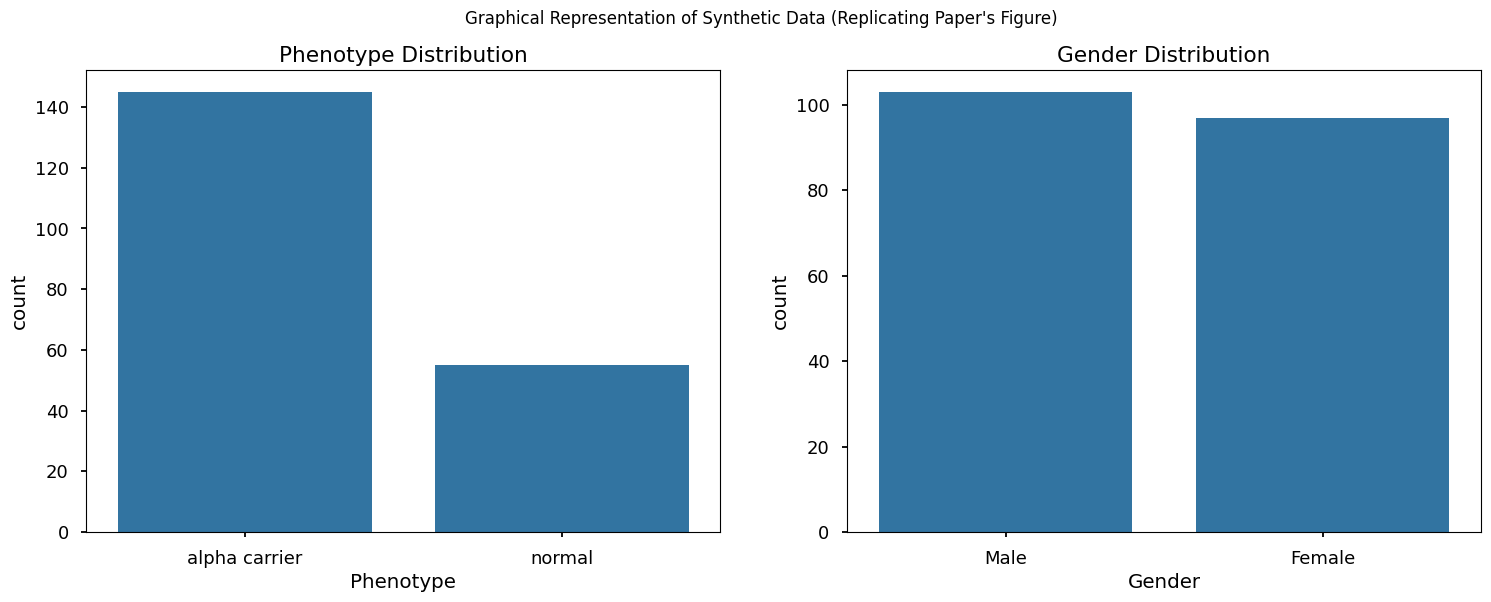

In [3]:
# --- 2. Exploratory Data Analysis (EDA) ---
# This step analyzes the data to understand its properties.
print("--- Exploratory Data Analysis ---")
print(data.info())
print("\nData Description:")
print(data.describe())

# Replicating the plots from the paper
plt.style.use('seaborn-v0_8-talk')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(ax=axes[0], x='Phenotype', data=data.replace({'Phenotype': {1: 'alpha carrier', 0: 'normal'}}))
axes[0].set_title('Phenotype Distribution')

sns.countplot(ax=axes[1], x='Gender', data=data)
axes[1].set_title('Gender Distribution')

plt.suptitle('Graphical Representation of Synthetic Data (Replicating Paper\'s Figure)')
plt.show()


In [4]:
# --- 3. Data Preprocessing ---
# The paper mentions encoding categorical variables and normalization[cite: 32].
print("\n--- Data Preprocessing ---")

# Encode 'Gender'
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
print("Gender column encoded (Male=1, Female=0).")

# Define features (X) and target (y)
X = data.drop('Phenotype', axis=1)
y = data['Phenotype']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# The paper uses SMOTE to handle class imbalance [cite: 120, 125]
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("SMOTE applied to balance the training data.")
print("Original training class distribution:", y_train.value_counts().to_dict())
print("SMOTE-resampled training class distribution:", y_train_smote.value_counts().to_dict())


# Scale numerical features [cite: 36]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
print("Numerical features have been scaled using StandardScaler.")


--- Data Preprocessing ---
Gender column encoded (Male=1, Female=0).
Data split into 140 training samples and 60 testing samples.
SMOTE applied to balance the training data.
Original training class distribution: {1: 102, 0: 38}
SMOTE-resampled training class distribution: {0: 102, 1: 102}
Numerical features have been scaled using StandardScaler.



--- Model Training and Evaluation ---

----- K-Nearest Neighbors -----
Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.95      0.98        43

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60



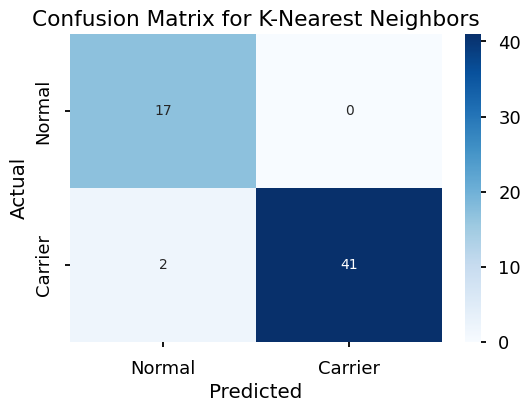


----- Support Vector Machine -----
Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.95      0.98        43

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60



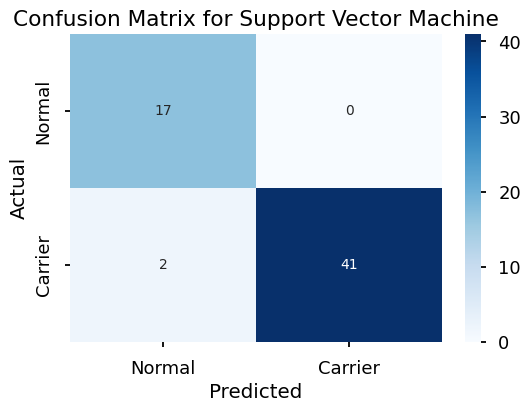


----- Naive Bayes -----
Accuracy: 0.9833
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.98      0.99        43

    accuracy                           0.98        60
   macro avg       0.97      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



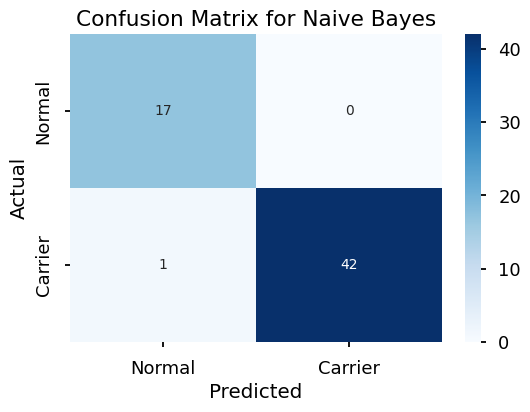


----- Random Forest -----
Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.95      0.98        43

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60



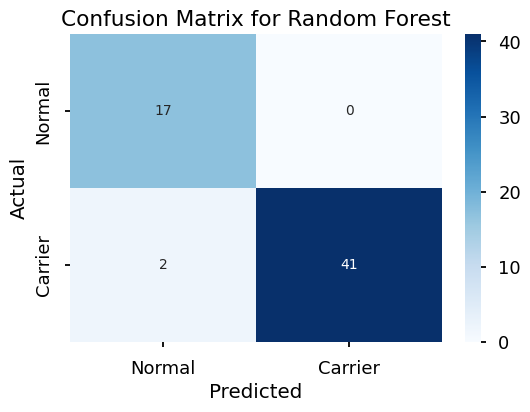

In [5]:
# --- 4. Model Training and Evaluation ---
# The paper compares KNN, SVM, Naive Bayes, and Random Forest[cite: 12, 13, 124].
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

print("\n--- Model Training and Evaluation ---")
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train_smote)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        'Accuracy': accuracy,
        'Precision (0)': report['0']['precision'],
        'Recall (0)': report['0']['recall'],
        'F1-Score (0)': report['0']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'F1-Score (1)': report['1']['f1-score']
    }

    print(f"\n----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Carrier'], yticklabels=['Normal', 'Carrier'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [6]:
# --- 5. Results Comparison ---
# The paper concludes that Random Forest performs best[cite: 136, 139].
# We'll display the results in a comparative table.
results_df = pd.DataFrame(results).T
print("\n--- Comparative Model Performance ---")
print(results_df)

print("\n--- Conclusion ---")
print("Based on the evaluation metrics, the Random Forest classifier demonstrates strong and balanced performance,")
print("aligning with the paper's conclusion that it is a highly effective model for Alpha Thalassemia prediction[cite: 141].")



--- Comparative Model Performance ---
                        Accuracy  Precision (0)  Recall (0)  F1-Score (0)  \
K-Nearest Neighbors     0.966667       0.894737         1.0      0.944444   
Support Vector Machine  0.966667       0.894737         1.0      0.944444   
Naive Bayes             0.983333       0.944444         1.0      0.971429   
Random Forest           0.966667       0.894737         1.0      0.944444   

                        Precision (1)  Recall (1)  F1-Score (1)  
K-Nearest Neighbors               1.0    0.953488      0.976190  
Support Vector Machine            1.0    0.953488      0.976190  
Naive Bayes                       1.0    0.976744      0.988235  
Random Forest                     1.0    0.953488      0.976190  

--- Conclusion ---
Based on the evaluation metrics, the Random Forest classifier demonstrates strong and balanced performance,
aligning with the paper's conclusion that it is a highly effective model for Alpha Thalassemia prediction[cite: 141].